TLDR: this notebook illustrated 'missing' LSST sources-  those sources that were detected in DECAPS, but no in LSST... 

In [2]:
import astropy.visualization as vis
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
import urllib.request
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.table import hstack
from astropy.table import vstack
from astropy import wcs
from itertools import product
from scipy.stats import binned_statistic as bs

In [3]:
visit = 611980 # 525951 # 
decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')



In [4]:
decaps_lsst

decaps_mag,decaps_magerr,decaps_ra,decaps_dec,decaps_flags,decaps_x,decaps_y,decaps_ccdnum,lsst_mag,lsst_magerr,lsst_ra,lsst_dec,ccdnum,d2darcsec,dmag,lsst_match
float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,int64
17.3506164551,0.00328853121027,120.385017714,-23.1161541693,1,16.8330369173,871.953976348,1,21.1209235123,0.045641013904,2.10116703237,-0.403435714584,1,10.5076476006,-3.77030705723,0
20.0446243286,0.0190205648541,120.385599091,-23.0976747715,1,23.1708864639,618.603869273,1,20.3402508241,0.0241608192136,2.10116141178,-0.403148703762,1,7.8526867598,-0.295626495437,0
19.8299636841,0.0161599330604,120.385801944,-23.0648149394,1,24.0479005,168.266999971,1,14.3705574443,0.000828437015239,2.10123447931,-0.40261927675,1,23.8498579044,5.45940623973,0
20.4198760986,0.0256946254522,120.385700367,-23.1058405108,1,24.8787026692,730.53758293,1,22.3216712905,0.131107824943,2.10117212372,-0.403281797014,1,8.78026626665,-1.90179519188,0
20.3417205811,0.0260351207107,120.386217061,-23.0557522337,1,28.8328668977,44.086195472,1,14.3705574443,0.000828437015239,2.10123447931,-0.40261927675,1,49.1794909042,5.97116313671,0
18.4471549988,0.00602161511779,120.386474022,-23.0929139617,1,33.9449076989,553.319969399,1,18.5120519982,0.00663196358959,2.10114030768,-0.403047500547,1,0.0254393760339,-0.0648969994,1
22.1130485535,0.110767886043,120.386895922,-23.0817270906,1,38.6838476063,399.982130346,1,22.318720793,0.132644700491,2.10114778347,-0.402852241268,1,0.0260070163346,-0.205672239582,1
17.7199001312,0.00382045842707,120.386705088,-23.1271184242,1,38.6868817087,1022.23943857,1,17.7884436664,0.00434574196324,2.10114435388,-0.403644482726,1,0.0251657880342,-0.0685435352052,1
19.6484127045,0.0143161043525,120.387490148,-23.0584773926,1,45.0089246472,81.3778840991,1,14.3705574443,0.000828437015239,2.10123447931,-0.40261927675,1,38.502647345,5.27785526012,0


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


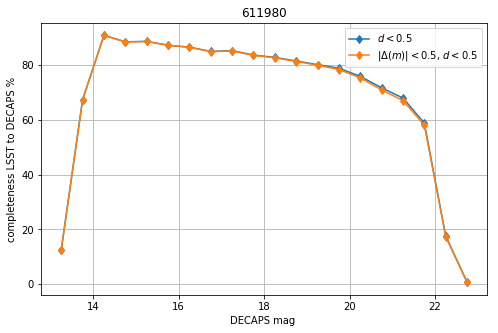

In [2]:
visit = 611980 # 525951 # 
decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')

%matplotlib inline
# plot quick completeness plot 
def plot_completeness(decaps_lsst, visit,ax,bins,decaps_match,label):
    # Plot completeness for this single visit ...    
    stat_decaps = bs(decaps_lsst['decaps_mag'], decaps_lsst['decaps_mag'] , 
                  bins = bins , statistic='count')
    decaps_count = stat_decaps.statistic

    stat_matched = bs(decaps_lsst['decaps_mag'], decaps_match , 
                      bins =bins , statistic=np.sum)
    lsst_matched_count = stat_matched.statistic
    completeness = 100 * (lsst_matched_count / decaps_count)

    # plot 
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    ax.plot(bin_centers, completeness, marker='d',label=label)
    #ax.scatter(bin_centers, completeness)
    
    
fig,ax = plt.subplots(1,1,figsize=(8,5))
bins = np.arange(13,24,0.5)

decaps_match = np.array(decaps_lsst['d2darcsec'] <0.5).astype(int)
label = r'$d < 0.5"$'
plot_completeness(decaps_lsst, visit, ax, bins,decaps_match,label)

mask_dist = decaps_lsst['d2darcsec'] <0.5

dmag = decaps_lsst['decaps_mag'] - decaps_lsst['lsst_mag']
cut_mag = 0.5
mask_mag = abs(dmag) < cut_mag

decaps_match = np.array(mask_dist*mask_mag).astype(int)
label=r'$|\Delta(m)|<0.5$'+', '+r'$d < 0.5"$'
plot_completeness(decaps_lsst, visit, ax, bins,decaps_match,label)
ax.set_title(str(visit))
ax.set_xlabel('DECAPS mag ')
ax.set_ylabel('completeness LSST to DECAPS %')
ax.grid()
ax.legend()

Investigating DECAPS mag  10 - 24
Using only d2d < 0.5 arcsec
decaps with lsst match 3246
Saving as  visit_611980_ccd1010-24d2d_good.png


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


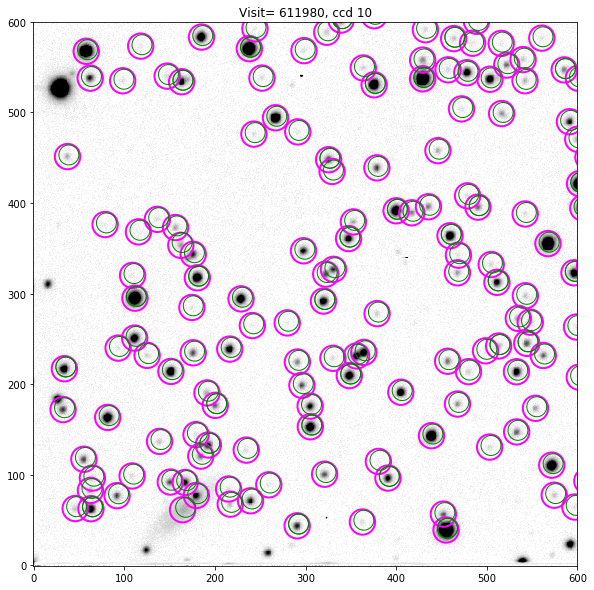

In [85]:
# Illustrate mismatches in each density bin...
# Since it doesn't matter whether we use the 0.5 mag difference 
# or not,  let's just use the built-in decaps_match column,
# which uses the criterion d < 0.5'',  |dmag| < 0.5 

# Parse the WCS keywords in the primary HDU
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
ccdnum = '10'
ccd_num = int(ccdnum)
mag_bins = np.arange(13,24,1)
choose_ccd = decaps_lsst['decaps_ccdnum'] == ccd_num

mag_selection = True 
if mag_selection : 
    i=0
    mag = decaps_lsst['decaps_mag']
    mag_min,mag_max = 10,24 # mag_bins[i] ,  mag_bins[i+1]
    print('Investigating DECAPS mag ',mag_min  ,'-',mag_max)
    choose_mag = (mag_min<mag)*(mag<mag_max)

outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'
calexp_file = 'calexp-0'+str(visit)+'_'+ccdnum+'.fits'
calexp_hdu = fits.open(outDir +'calexp/'+ calexp_file)

# grab the LSST mask and image data 
image_data = calexp_hdu[1].data
mask_data = calexp_hdu[2].data
fig,ax = plt.subplots(1,1,figsize=(10,10))

xmin,xmax =0,600
ymin,ymax = 0,600
# show a small region of that CCD 
norm = ImageNormalize(stretch=SqrtStretch())
ax.imshow(image_data[xmin:xmax, ymin:ymax].T,
         cmap='Greys', origin='lower', norm=norm,
         vmax = 500, vmin = 2)

# choose a way of selecting matches / mismatches ...
use_only_separation = True 
if use_only_separation  :
    print('Using only d2d < 0.5 arcsec')
    mask_distance = decaps_lsst['d2darcsec'] <0.5
    choose_matches  = mask_distance 
    choose_mismatches = np.bitwise_not(mask_distance)
    
else : # separation and |dmag| < 0.5  
    choose_mismatches = decaps_lsst['lsst_match'] == 0
    choose_matches = decaps_lsst['lsst_match'] == 1 
    
# plot decaps sources that lack LSST match 
plot_bad_decaps = False
if plot_bad_decaps is True : 
    mask = choose_mismatches * choose_ccd * choose_mag 
    print('decaps missing lsst match ',np.sum(mask))
    xcords = decaps_lsst[mask]['decaps_x']# 
    ycords = decaps_lsst[mask]['decaps_y'] #
    x = decaps_lsst[mask]['decaps_mag']
    normed_color  = (x-min(x))/(max(x)-min(x))
    import matplotlib
    cmap = matplotlib.cm.get_cmap('jet')
    color= cmap(normed_color)
    patches = []
    for xx,yy, ec in zip(xcords-xmin,ycords-ymin, color):
        # https://matplotlib.org/devdocs/api/_as_gen/matplotlib.patches.Circle.html 
        #color = cmap((i+1)/N)
        circ = Circle((xx,yy), radius=9,alpha=1, fill=False, lw=2,ec='red', 
                     label='decaps source')
        #patches.append(circ)
        ax.add_patch(circ)
        
# plot decaps sources that have LSST match 
plot_good_decaps = True 
if plot_good_decaps is True : 
    mask = choose_ccd *  choose_matches  * choose_mag 
    print('decaps with lsst match',np.sum(mask))
    xcords = decaps_lsst[mask]['decaps_x']# 
    ycords = decaps_lsst[mask]['decaps_y'] #

    for xx,yy in zip(xcords-xmin,ycords-ymin):
        circ = Circle((xx,yy), radius=14,alpha=1, lw=2,fill=False, ec='magenta', 
                     label='decaps source')
        ax.add_patch(circ) 
        
# plot all lsst sources
plot_lsst = True
if plot_lsst is True :       
    # also plot all the LSST detections ....
    lsst_clean = Table.read('lsst_clean_'+str(visit)+'.txt', format='ascii')

    # select CCD 
    mask_ccd = lsst_clean['ccdnum'] == ccd_num
    #mask_mag = (mag_min < lsst_clean['lsst_mag'] )*(lsst_clean['lsst_mag']<mag_max)
    lsst = lsst_clean[mask_ccd]
    
    # convert ra,dec to CCD coords ...
    w = wcs.WCS(calexp_hdu[1].header)

    # first need to express the ra,dec in terms of pixel location on the image ...
    radec_lsst = np.column_stack((360*lsst['lsst_ra'] / (2*np.pi), 
                                  360*lsst['lsst_dec']/(2*np.pi)))
    pixcrd_lsst = w.wcs_world2pix(radec_lsst,1)

    # make columns for lsst  ra,dec based x,y coords
    xcords = np.ravel(np.hsplit(pixcrd_lsst,2)[1])
    ycords = np.ravel(np.hsplit(pixcrd_lsst,2)[0])   

    for xx,yy in zip(xcords-xmin,ycords-ymin):
        circ = Circle((xx,yy), radius=11,alpha=1, fill=False, ec='green', 
                     label='decaps source')
        ax.add_patch(circ)
        
plot_mask = False
if plot_mask : 
    mask_filter  = (2**0 + 2**1 + 2**2 + 2**3 + 2**4 + 2**6 + 2**7 + 2**8)
    ax.imshow(mask_data[xmin:xmax, ymin:ymax].astype(int).T & mask_filter, 
            cmap='Greys', origin='lower', norm=norm,
             vmax = 1, vmin = 0, alpha=0.8)

ax.set_title('Visit= '+str(visit)+ ', ccd ' + ccdnum)
if plot_mask :
    fname = 'visit_'+str(visit)+'_ccd'+ccdnum+str(mag_min)+'-'+str(mag_max)+'d2d_mask.png'
else : 
    fname = 'visit_'+str(visit)+'_ccd'+ccdnum+str(mag_min)+'-'+str(mag_max)+'d2d_good.png'
print('Saving as ', fname)
plt.savefig(fname, bbox_inches='tight')

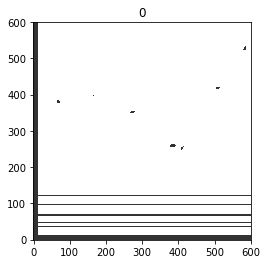

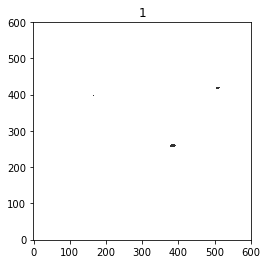

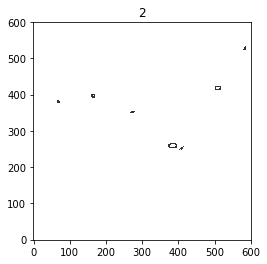

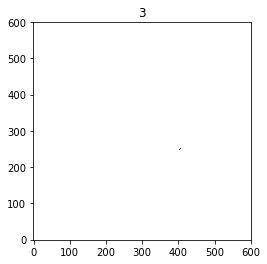

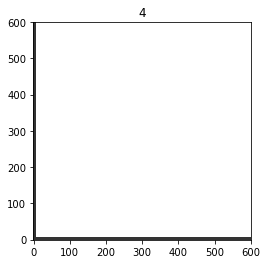

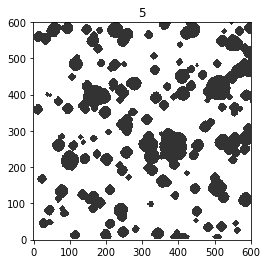

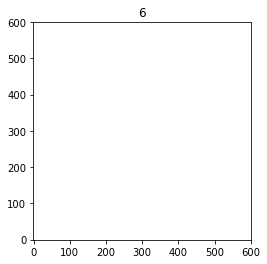

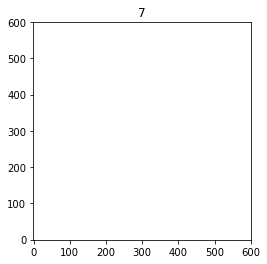

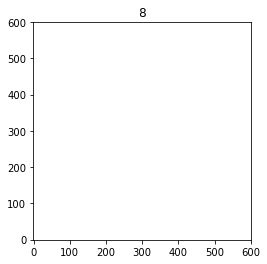

In [82]:
# Show what individual values of the mask look like ...
for i in range(9):
    mask_filter  = (2**i ) #+ 2**1 + 2**2 + 2**3 + 2**4 + 2**6 + 2**7 + 2**8)
    plt.title(i)
    plt.imshow(mask_data[xmin:xmax, ymin:ymax].astype(int).T & mask_filter, 
                cmap='Greys', origin='lower', norm=norm,
                 vmax = 1, vmin = 0, alpha=0.8)
    plt.show()


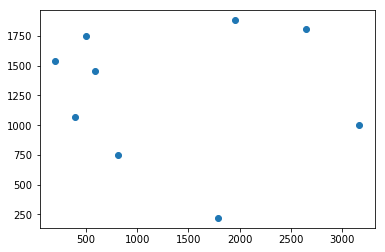

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


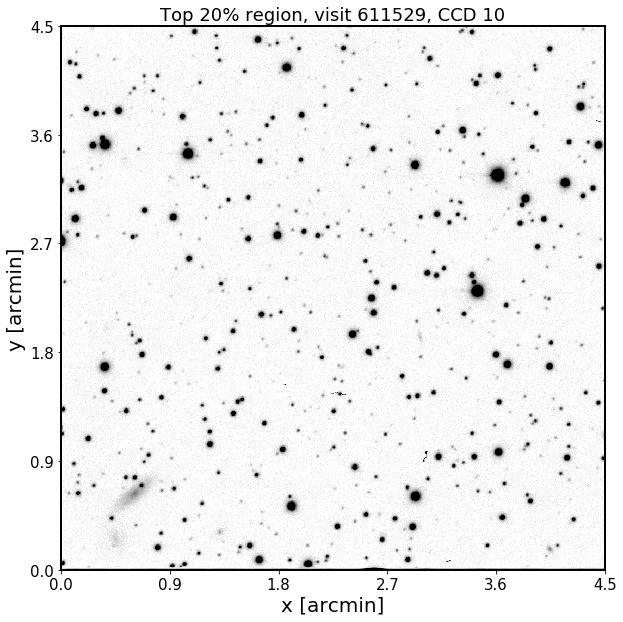

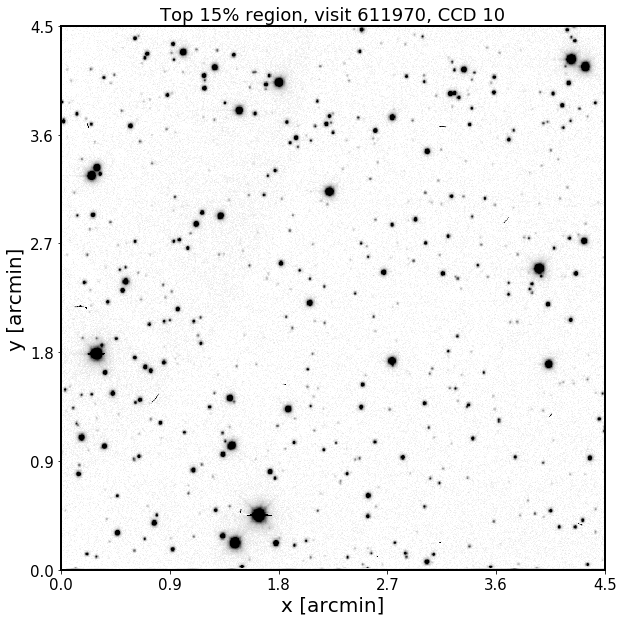

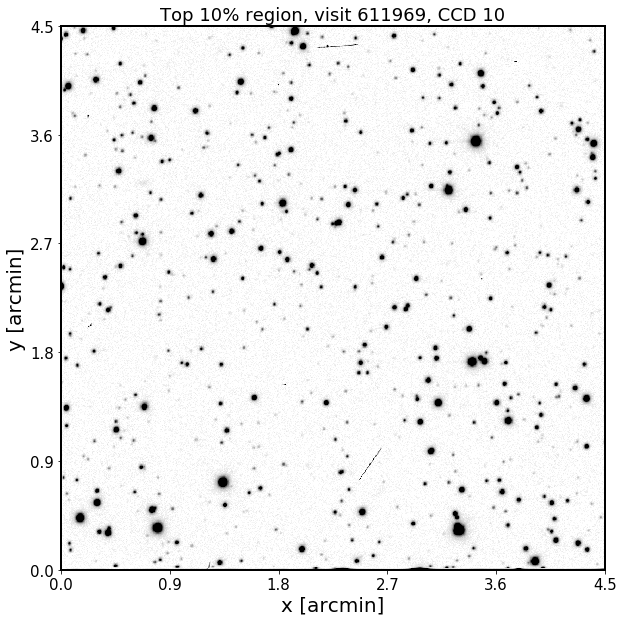

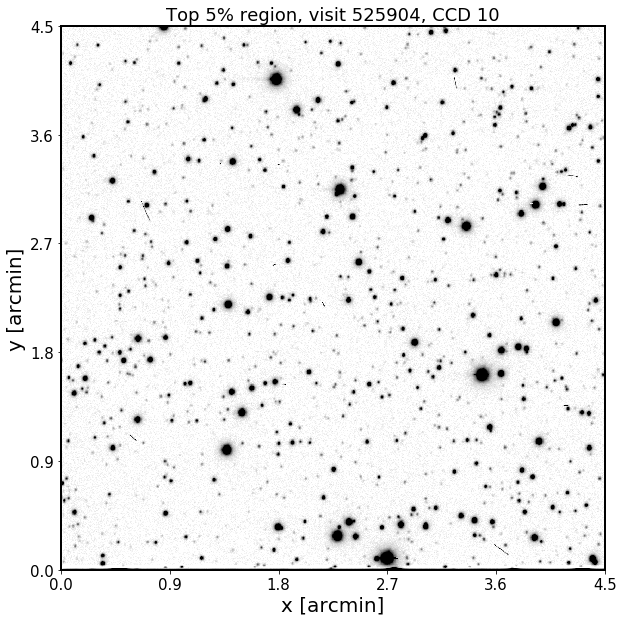

In [98]:
# Illustrate different densities ....

from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


visit_density_dic = {'20':[611529,609754,525814,525900],
                     '15':[611970,525837,525838],
                     '10':[611969,525846,525879],
                     '5':[525904,525920]}    

for density in list(visit_density_dic.keys()):
    visit = visit_density_dic[density][0]  
    ccdnum = '10'
    ccd_num = int(ccdnum)

    outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'
    calexp_file = 'calexp-0'+str(visit)+'_'+ccdnum+'.fits'
    calexp_hdu = fits.open(outDir +'calexp/'+ calexp_file)

    # grab the LSST mask and image data 
    image_data = calexp_hdu[1].data
    mask_data = calexp_hdu[2].data
    fig,ax = plt.subplots(1,1,figsize=(10,10))

    xmin,xmax =0,1000
    ymin,ymax = 0,1000
    # show a small region of that CCD 
    norm = ImageNormalize(stretch=SqrtStretch())
    ax.imshow(image_data[xmin:xmax, ymin:ymax].T,
             cmap='Greys', origin='lower', norm=norm,
             vmax = 500, vmin = 2)

    x_px_scale = calexp_hdu[0].header['PIXSCAL1']
    y_px_scale = calexp_hdu[0].header['PIXSCAL2']

    plot_lsst = False
    if plot_lsst is True :       
        # also plot all the LSST detections ....
        lsst_clean = Table.read('lsst_clean_'+str(visit)+'.txt', format='ascii')

        # select CCD 
        mask_ccd = lsst_clean['ccdnum'] == ccd_num
        #mask_mag = (mag_min < lsst_clean['lsst_mag'] )*(lsst_clean['lsst_mag']<mag_max)
        lsst = lsst_clean[mask_ccd]

        # convert ra,dec to CCD coords ...
        w = wcs.WCS(calexp_hdu[1].header)

        # first need to express the ra,dec in terms of pixel location on the image ...
        radec_lsst = np.column_stack((360*lsst['lsst_ra'] / (2*np.pi), 
                                      360*lsst['lsst_dec']/(2*np.pi)))
        pixcrd_lsst = w.wcs_world2pix(radec_lsst,1)

        # make columns for lsst  ra,dec based x,y coords
        xcords = np.ravel(np.hsplit(pixcrd_lsst,2)[1])
        ycords = np.ravel(np.hsplit(pixcrd_lsst,2)[0])   

        for xx,yy in zip(xcords-xmin,ycords-ymin):
            circ = Circle((xx,yy), radius=11,alpha=1, fill=False, ec='green', 
                         label='decaps source')
            ax.add_patch(circ)
   
    # translate x ticks to arcsec
    new_labels = [str((item +xmin) * x_px_scale / 60) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels)

    # translate y ticks to arcsec
    new_labels = [str((item +ymin)* y_px_scale/60) for item in ax.get_yticks()]
    ax.set_yticklabels(new_labels)
    ax.set_title('Top '+density+'% region, visit '+str(visit)+', CCD '+ccdnum)
    ax.set_xlabel('x [arcmin]')
    ax.set_ylabel('y [arcmin]')
    
    plt.savefig('ill_dens_'+density+'_visit'+str(visit)+'_ccd'+ccdnum+'_plain.png', 
                bbox_inches='tight')

0.27